# LangGraph Practice

In this notebook, we will build a basic agent using the **LangGraph** framework. We will cover:
1.  Creating a basic agent.
2.  Using standard tools.
3.  Simulating an **MCP (Model Context Protocol)** tool.
4.  Observing the agent's execution steps.

We will use OpenAI's **GPT-4.1-mini** model.

## 1. Prerequisites and Installation
First, let's install the necessary libraries.

In [1]:
%pip install -qU langgraph langchain langchain-openai langchain-core pydantic

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Setup Environment Variables
We need to set up the `OPENAI_API_KEY` and `OPENAI_BASE_URL` to use the GPT-4.1-mini model.

In [2]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key: ")

if "OPENAI_BASE_URL" not in os.environ:
    os.environ["OPENAI_BASE_URL"] = getpass.getpass("Enter your OpenAI Base URL: ")

### 2.1 Setup Observability (LangSmith)
To visualize the agent's steps, we will use LangSmith. You can sign up for a free account at [smith.langchain.com](https://smith.langchain.com/).

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangSmith API Key: ")

## 3. Initialize the OpenAI Model
We will use `ChatOpenAI` with the `gpt-4.1-mini` model.

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0,
    base_url=os.environ["OPENAI_BASE_URL"]
)

c:\Users\edvard.smoliakov\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 4. Define a Basic Calculator Tool
We'll create a simple multiplication tool.

In [5]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiplies two integers."""
    return a * b

print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiplies two integers.
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


## 5. Define an MCP Tool (Mock Weather Service)
The **Model Context Protocol (MCP)** is a standard for connecting AI models to external data and tools.
Here, we will simulate an MCP tool that fetches weather data. In a real scenario, this would connect to an MCP server.

In [6]:
@tool
def get_weather_mcp(city: str) -> str:
    """
    Fetches weather data for a given city.
    This tool simulates an MCP tool interaction.
    """
    # In a real MCP implementation, this would make a request to an MCP server.
    # client.call_tool("weather_server", "get_weather", {"city": city})

    mock_data = {
        "London": "Rainy, 15°C",
        "New York": "Sunny, 22°C",
        "Tokyo": "Cloudy, 18°C"
    }
    return mock_data.get(city, "Weather data not available for this city.")

tools = [multiply, get_weather_mcp]
llm_with_tools = llm.bind_tools(tools)

## 6. Define the Agent State
We need a state to hold the conversation history.

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## 7. Create Nodes
We define the **Agent Node** (which calls the model) and the **Tool Node** (which executes tools).

In [8]:
from langgraph.prebuilt import ToolNode

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

tool_node = ToolNode(tools)

## 8. Build the LangGraph Workflow
We connect the nodes and define the logic.

In [9]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")

def route_tools(state: State):
    if state["messages"][-1].tool_calls:
        return "tools"
    return END

graph_builder.add_conditional_edges("chatbot", route_tools, {"tools": "tools", END: END})
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile()

## 9. Visualize the Graph

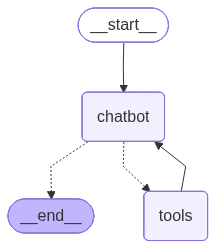

In [10]:
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Could not draw graph (requires graphviz/mermaid support).")
    graph.get_graph().print_ascii()

## 10. Run the Agent with Observability
We can now run the agent. LangGraph provides built-in observability by allowing us to stream the steps.

In [11]:
user_input = "What is 5 times 8? Also, what is the weather in London?"

events = graph.stream(
    {"messages": [("user", user_input)]},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is 5 times 8? Also, what is the weather in London?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vAkFtc1bnGXgxN8BdzLbjm10)
 Call ID: call_vAkFtc1bnGXgxN8BdzLbjm10
  Args:
    a: 5
    b: 8
  get_weather_mcp (call_BpDOvLbHCZTTRTCmGzrQAYKL)
 Call ID: call_BpDOvLbHCZTTRTCmGzrQAYKL
  Args:
    city: London
================================= Tool Message =================================
Name: get_weather_mcp

Rainy, 15°C
================================== Ai Message ==================================

5 times 8 is 40. The weather in London is rainy with a temperature of 15°C.


## 11. Observe the run in Langsmith

## 12. Challenge: Build a Travel Assistant

Now it's your turn! Apply what you've learned to build a **Travel Assistant Agent**.

**Requirements:**
1.  **Create a Tool**: `calculate_distance(origin: str, destination: str) -> int`. Return a mock distance (e.g., based on the length of the city names or just a random number).
2.  **Create an MCP Tool**: `get_hotel_recommendations_mcp(city: str) -> str`. Return a mock list of hotels for the given city.
3.  **Build the Graph**: Create a new `StateGraph` with a new agent node and tool node.
4.  **Run**: Ask the agent: *"I want to travel from New York to Paris. How far is it and can you recommend a hotel?"*
5.  **Observe**: Use the streaming output to verify the tools are called correctly.

In [ ]:
# TODO: Implement your Travel Assistant here

# 1. Define tools
@tool
def calculate_distance(origin: str, destination: str) -> int:
    """Calculates the distance between two cities in km."""
    distance = len(origin) + len(destination) + 100
    return distance

@tool
def get_hotel_recommendations_mcp(city: str) -> str:
    """Fetches hotel recommendations for a city."""
    hotels = {
        "Vilnius": "Hotel Gediminas",
        "Riga": "Hotel Jurmala",
        "Warsaw": "Hotel Pierogi"
    }
    return hotels.get(city, "Hotel data not available for this city.")


# 2. Bind tools to LLM
travel_tools = [calculate_distance, get_hotel_recommendations_mcp]
llm_travel = llm.bind_tools(travel_tools)


# 3. Define Agent Node
def travel_agent(state: State):
    return {"messages": [llm_travel.invoke(state["messages"])]}

tool_node = ToolNode(travel_tools)


# 4. Build Graph
travel_graph = StateGraph(State)

travel_graph.add_node("chatbot", travel_agent)
travel_graph.add_node("tools", tool_node)

travel_graph.add_edge(START, "chatbot")

def route_tools(state: State):
    if state["messages"][-1].tool_calls:
        return "tools"
    return END

travel_graph.add_conditional_edges("chatbot", route_tools, {"tools": "tools", END: END})
travel_graph.add_edge("tools", "chatbot")

graph = travel_graph.compile()


# 5. Run and Observe
user_input = "I want to travel from Vilnius to Riga. How far is it and can you recommend a hotel?"

events = graph.stream(
    {"messages": [("user", user_input)]},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to travel from Vilnius to Riga. How far is it and can you recommend a hotel?
================================== Ai Message ==================================
Tool Calls:
  calculate_distance (call_4Jopq9b28zVsWm3AgsI9vEaM)
 Call ID: call_4Jopq9b28zVsWm3AgsI9vEaM
  Args:
    origin: Vilnius
    destination: Riga
  get_hotel_recommendations_mcp (call_oJBlyVvDtxcJ7GY6PjtiCPGq)
 Call ID: call_oJBlyVvDtxcJ7GY6PjtiCPGq
  Args:
    city: Riga
================================= Tool Message =================================
Name: get_hotel_recommendations_mcp

Hotel Jurmala
================================== Ai Message ==================================

The distance from Vilnius to Riga is approximately 111 km. For your stay in Riga, I recommend Hotel Jurmala. If you need more hotel options or additional information, feel free to ask!
